In [6]:
import numpy as np
import librosa
import librosa.display

## Set Config

In [66]:
import os
from easydict import EasyDict

conf = EasyDict()

# Basic configurations
conf.sampling_rate = 44100
conf.duration = 1
conf.hop_length = 347  # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20
conf.model = 'mobilenetv2'  # 'alexnet'

# Labels
conf.labels = ['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock',
               'Gunshot_or_gunfire', 'Clarinet', 'Computer_keyboard',
               'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing',
               'Fart', 'Oboe', 'Flute', 'Cough', 'Telephone', 'Bark', 'Chime',
               'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica', 'Gong',
               'Microwave_oven', 'Burping_or_eructation', 'Double_bass', 'Shatter',
               'Fireworks', 'Tambourine', 'Cowbell', 'Electric_piano', 'Meow',
               'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
               'Violin_or_fiddle', 'Finger_snapping']

conf.samples = conf.sampling_rate * conf.duration

## Recorded Sounds

In [67]:
!ls sounds/

1115003250.wav 1115024507.wav 1115081410.wav 1119163420.wav 1121034207.wav
1115003252.wav 1115024512.wav 1115081415.wav 1119163429.wav 1121034211.wav
1115003300.wav 1115024516.wav 1115081642.wav 1119163430.wav 1121034759.wav
1115003301.wav 1115024604.wav 1115081643.wav 1119163500.wav 1121034803.wav
1115003306.wav 1115024608.wav 1115081644.wav 1119164029.wav 1121034926.wav
1115003307.wav 1115024621.wav 1115081651.wav 1119165523.wav 1121035005.wav
1115003308.wav 1115024624.wav 1115081657.wav 1119165536.wav 1121035052.wav
1115003309.wav 1115024736.wav 1115081838.wav 1119165549.wav 1121035548.wav
1115003310.wav 1115024737.wav 1115081841.wav 1119165603.wav 1121035615.wav
1115004500.wav 1115024740.wav 1115081843.wav 1119165610.wav 1121035706.wav
1115004501.wav 1115024741.wav 1115081846.wav 1119165622.wav 1121035847.wav
1115004753.wav 1115024743.wav 1115081847.wav 1119172305.wav 1121040039.wav
1115004755.wav 1115024744.wav 1118132314.wav 1119172312.wav 1121040055.wav
1115005008.wav 1115024745

## Load Sound

In [142]:
fname = "./sounds/1119144656.wav"

In [143]:
y, sr = librosa.load(fname, sr=conf.sampling_rate)

# trim silence
if 0 < len(y):  # workaround: 0 length causes error
    y_short, _ = librosa.effects.trim(y)  # trim, top_db=default(60)

    # make it unified length to conf.samples
if len(y) > conf.samples:  # long enough
    # cut long file
    pass
    #     y = y[0:0+conf.samples]
else:  # pad blank
    padding = conf.samples - len(y)    # add padding at both ends
    offset = padding // 2
    y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')

In [144]:
y.shape

(69632,)

In [145]:
y_short.shape

(69632,)

In [146]:
onset_frames = librosa.onset.onset_detect(y, sr=conf.sampling_rate)
onsets = librosa.frames_to_time(onset_frames, sr=conf.sampling_rate)

onsets

array([0.2554195 , 0.54566893, 0.92879819, 1.09133787])

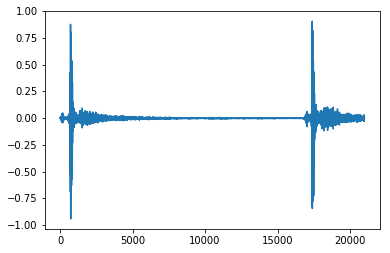

In [147]:
y_short, _ = librosa.effects.trim(y, top_db=20)
plt.plot(y_short)

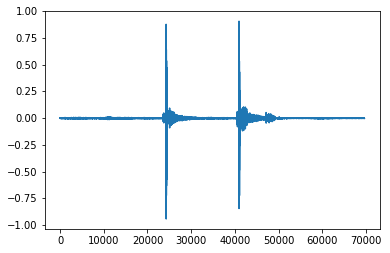

In [148]:
plt.plot(y)

In [152]:
y_short, _ = librosa.effects.trim(y, top_db=20)
fname_s = f"{fname[:-4]}_short.wav"
librosa.output.write_wav(fname_s, y_short, sr)

## Pitch Detection

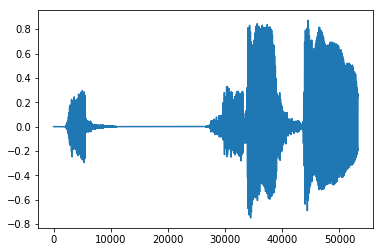

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(y)

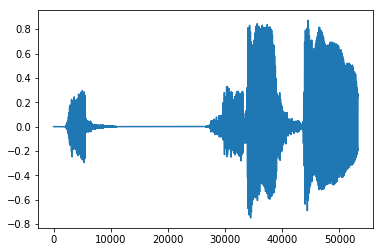

In [52]:
plt.plot(y_short)

In [108]:
import numpy as np

y_stft = np.abs(librosa.stft(y, n_fft=conf.n_fft))
y_short_stft = np.abs(librosa.stft(y_short, n_fft=conf.n_fft))

In [109]:
y_stft.shape

(1281, 69)

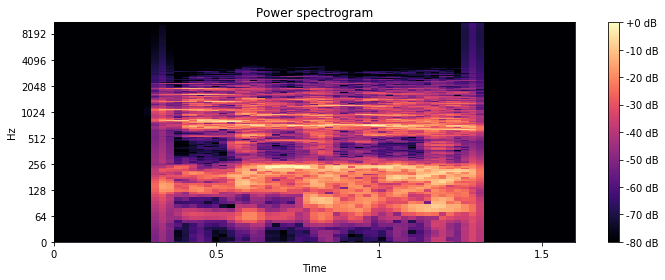

In [110]:
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(y_stft, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
 
plt.tight_layout()
plt.show()

In [111]:
librosa.fft_frequencies(sr=conf.sampling_rate, n_fft=conf.n_fft)

array([0.00000000e+00, 1.72265625e+01, 3.44531250e+01, ...,
       2.20155469e+04, 2.20327734e+04, 2.20500000e+04])

In [112]:
y_stft.shape

(1281, 69)

In [113]:
freqs_list = librosa.fft_frequencies(sr=conf.sampling_rate, n_fft=conf.n_fft)
freqs_list.shape

(1281,)

## Pitch Estimation

In [115]:
playfreq = freqs_list[np.argmax(np.median(y_stft, axis=1))]
playfreq_short = freqs_list[np.argmax(np.median(y_short_stft, axis=1))]
playfreq

1429.8046875

In [153]:
import IPython.display as ipd

ipd.Audio(fname) # load a local WAV file

In [154]:
ipd.Audio(fname_s) # load a local WAV file

In [117]:
sr = 44100 # sample rate
T = 3.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5 * np.sin(2 * np.pi * playfreq * t)                # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr) # load a NumPy array